In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform =  transforms.ToTensor()

# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
mnist_data = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,batch_size=64,shuffle=True)

![alt text](./images/autoencoder/image.png)

In [6]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)
print(torch.min(images), torch.max(images))

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor(0.) tensor(1.)


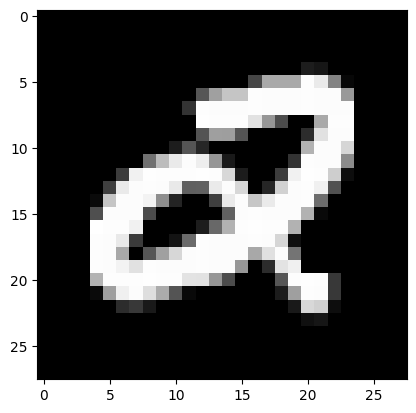

In [9]:
plt.imshow(images[0][0],cmap='gray')

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid() # making sure data range is between [0,1]
        )

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

# Note: [-1, 1] -> nn.Tanh()

![alt text](./images/autoencoder/image-1.png)
![alt text](./images/autoencoder/image-2.png)
![alt text](./images/autoencoder/image-3.png)

In [11]:
# model = Autoencoder()
model = Autoencoder().to(device) # to run on gpu
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [12]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 28*28).to(device)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item()}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.04298257827758789
Epoch:2, Loss:0.04475582018494606
Epoch:3, Loss:0.038290977478027344
Epoch:4, Loss:0.03851569816470146
Epoch:5, Loss:0.035291362553834915
Epoch:6, Loss:0.03920592740178108
Epoch:7, Loss:0.0393039770424366
Epoch:8, Loss:0.03798249736428261
Epoch:9, Loss:0.039890434592962265
Epoch:10, Loss:0.03845300152897835


0
4
8


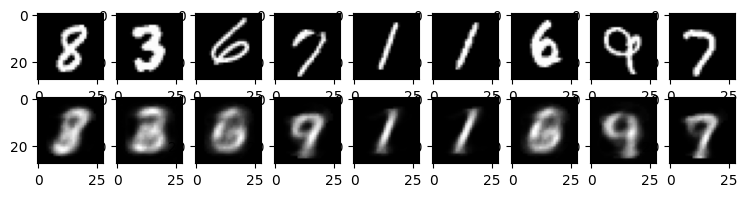

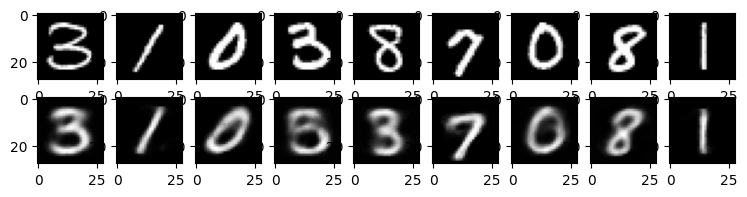

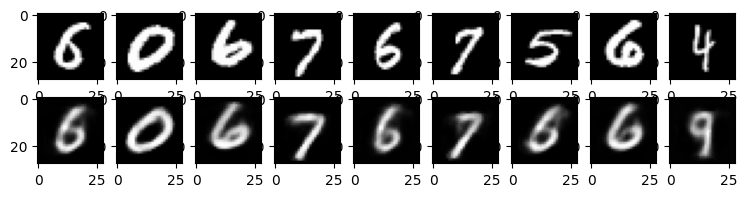

In [ ]:
for k in range(0, num_epochs, 4):
    print(k)
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28) # thi is done to reshape the image from 1,784 to 28,28
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

In [19]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        # N, 1, 28, 28
        super(Autoencoder_CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
model = Autoencoder_CNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [25]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item()}')
    outputs.append((epoch, img, recon))

g:\C_pan_copy_dir\.conda\envs\torch_gpu_env\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch:1, Loss:0.009676977060735226
Epoch:2, Loss:0.004961090628057718
Epoch:3, Loss:0.004678587429225445
Epoch:4, Loss:0.0041363853961229324
Epoch:5, Loss:0.003343938384205103
Epoch:6, Loss:0.0030193652492016554
Epoch:7, Loss:0.0027623181231319904
Epoch:8, Loss:0.002508360194042325
Epoch:9, Loss:0.003401858499273658
Epoch:10, Loss:0.0021886820904910564


0
4
8


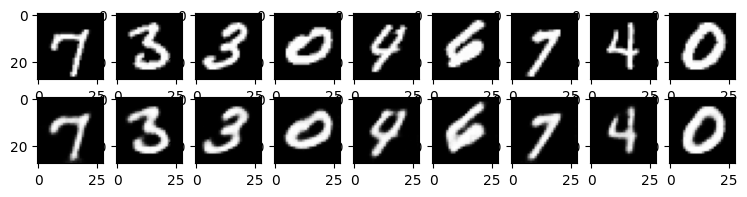

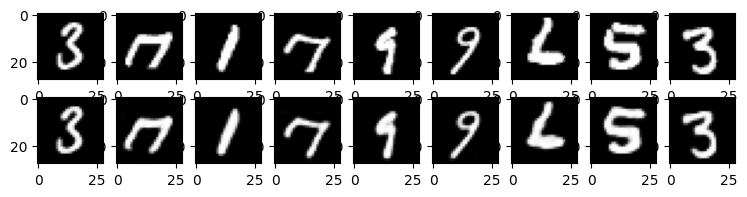

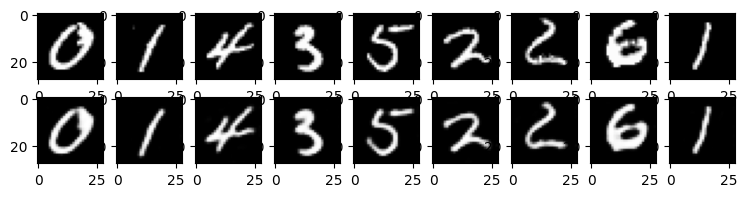

In [27]:
for k in range(0, num_epochs, 4):
    print(k)
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28) # thi is done to reshape the image from 1,784 to 28,28
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])